In [1]:
# loads a classic network
# converts it to FGN
# examine results over random noise
# train converted model and re-examine

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

momentsnotice           Fri Nov 20 15:14:49 2020  418.152.00
[0] GeForce GTX 1080 Ti | 66'C,   0 % |  7717 / 11178 MB | salami(7707M)
[1] GeForce GTX 1080 Ti | 63'C,   0 % |  7717 / 11178 MB | salami(7707M)


In [6]:
# Define what device we are using



print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)
# manualy set cuda device
if use_cuda: torch.cuda.set_device(1)

CUDA Available:  False
Using device: cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size = 1000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_size, 
                                                                                   batch_size_for_val=10000)

In [9]:
# load EMNIST letters data
(emnist_train_loader, emnist_val_loader, emnist_test_loader) = fgnh.emnist_letters_dataloaders(batch_size=batch_size, 
                                                                                          batch_size_for_val=10000)

In [10]:
# create random noisy images
rand_shuffled_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=10000, batch_size=10000)
rand_noise_dataloader = fgnh.mnist_random_dataloader(num_samples=10000, batch_size=10000)

<IPython.core.display.Javascript object>


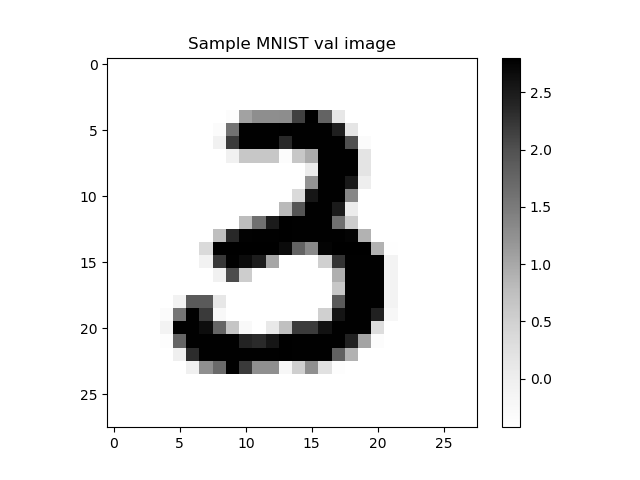

<IPython.core.display.Javascript object>


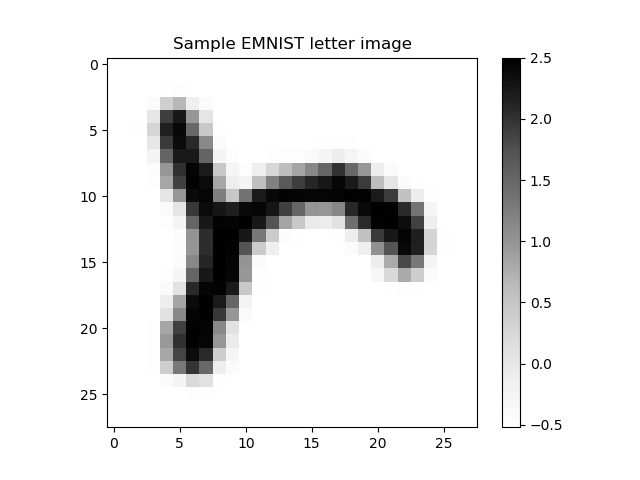

<IPython.core.display.Javascript object>


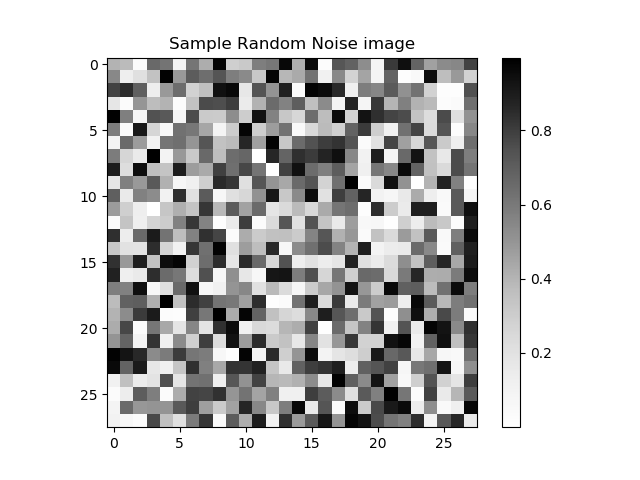

<IPython.core.display.Javascript object>


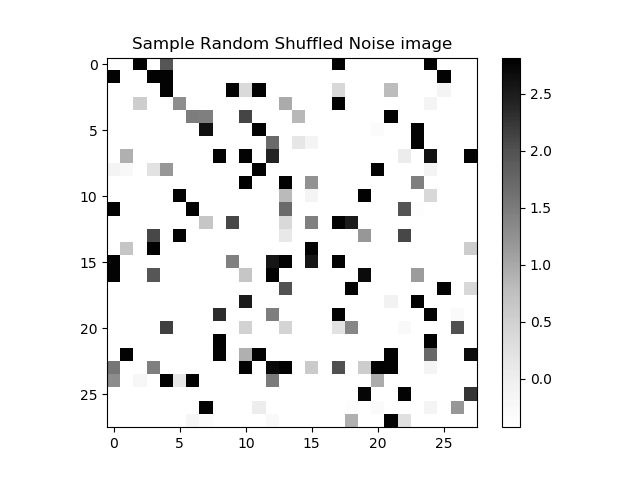

In [11]:
# plot samples
fgnh.plot_sample(mnist_val_loader, title='Sample MNIST val image')
fgnh.plot_sample(emnist_val_loader, title='Sample EMNIST letter image')
fgnh.plot_sample(rand_noise_dataloader, title='Sample Random Noise image')
fgnh.plot_sample(rand_shuffled_dataloader, title='Sample Random Shuffled Noise image')

# PART 1 - classic model 

In [12]:
# load a classic model
classic_model_path = '../Experiments/sample_models/sample_classic_full.pth'
classic_model = torch.load(classic_model_path, map_location=device)

In [13]:
# test the accuracy of the model
_ = fgnh.test(classic_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0320, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0934, Accuracy: 9739/10000 (97%)


<IPython.core.display.Javascript object>


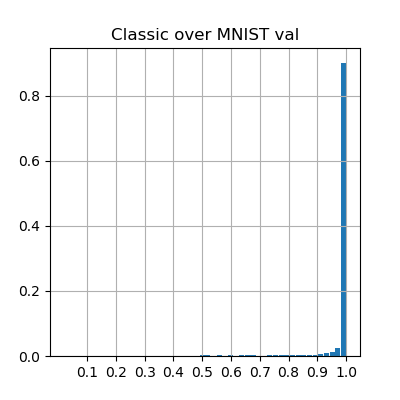

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.2927887318054155131, 0.99999246228105505627), mean=0.9822352481820308735, variance=0.00491725013060229019, skewness=-5.4000581828333788573, kurtosis=31.411645348935211226)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 1097 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 4992 prediction [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
index 1752 prediction [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index 6151 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9844 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [14]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, mnist_val_loader, title='Classic over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


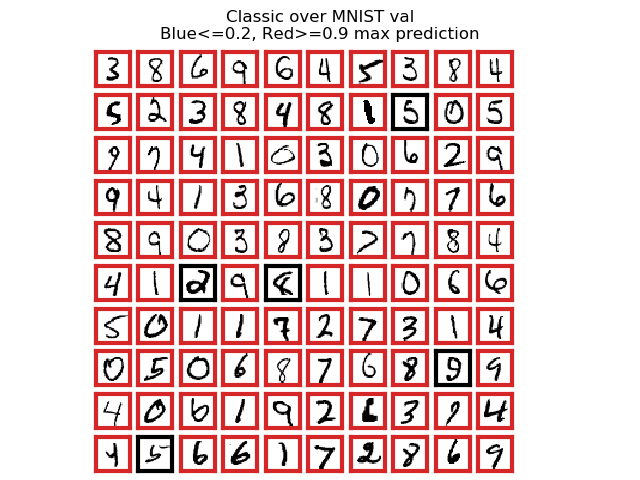

In [15]:
fgnh.plot_pred_samples_grid(classic_model, mnist_val_loader, title='Classic over MNIST val')

In [16]:
# over letters

<IPython.core.display.Javascript object>


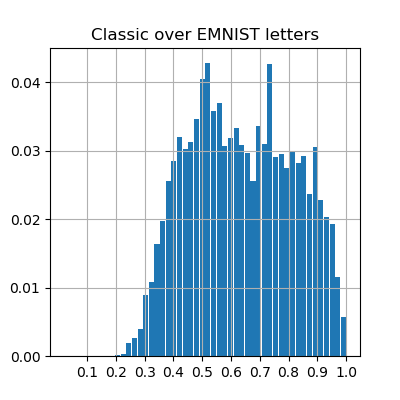

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.20994657714564037284, 0.99940672027375646546), mean=0.6362795185805415968, variance=0.032406017590596029548, skewness=0.05453505536081183961, kurtosis=-1.0232608622111416984)

percentage of confident predictions (>=0.5): 0.7336538461538461

Sample predictions
index 10076 prediction [0.   0.   0.02 0.06 0.03 0.06 0.   0.64 0.   0.19]
index 4806 prediction [0.   0.   0.04 0.19 0.07 0.53 0.   0.13 0.   0.03]
index 751 prediction [0.   0.01 0.01 0.02 0.02 0.05 0.   0.88 0.   0.02]
index 8642 prediction [0.   0.   0.   0.01 0.   0.03 0.   0.94 0.   0.01]
index 3243 prediction [0.   0.01 0.02 0.04 0.01 0.07 0.   0.83 0.   0.03]


In [17]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, emnist_val_loader, title='Classic over EMNIST letters' ,verbose=True)

<IPython.core.display.Javascript object>


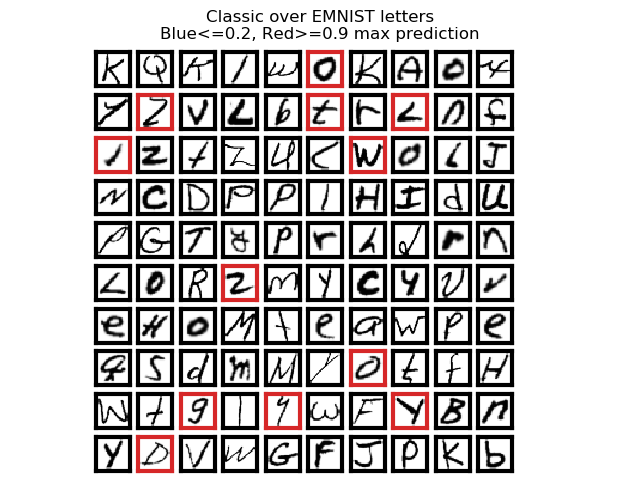

In [18]:
fgnh.plot_pred_samples_grid(classic_model, emnist_val_loader, title='Classic over EMNIST letters')

In [19]:
# over noise now

<IPython.core.display.Javascript object>


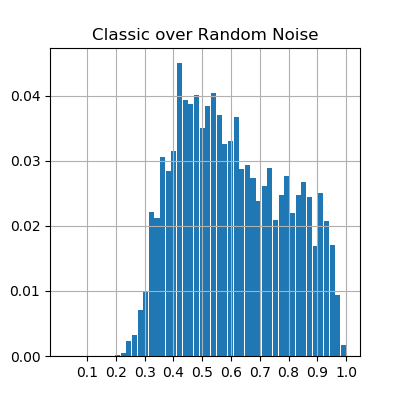

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.214335393235350631, 0.9986322605877910143), mean=0.6068410093940963749, variance=0.033576586153862599003, skewness=0.23044754487950069965, kurtosis=-1.0039374579949004827)

percentage of confident predictions (>=0.5): 0.6601

Sample predictions
index 1377 prediction [0.01 0.   0.   0.36 0.   0.53 0.08 0.   0.   0.  ]
index 2966 prediction [0.   0.15 0.54 0.22 0.   0.03 0.04 0.01 0.   0.  ]
index 1388 prediction [0.   0.01 0.83 0.12 0.   0.   0.02 0.01 0.   0.  ]
index 5032 prediction [0.   0.1  0.85 0.03 0.   0.   0.01 0.01 0.   0.  ]
index 5178 prediction [0.83 0.01 0.01 0.04 0.   0.08 0.02 0.   0.01 0.  ]


In [20]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, rand_noise_dataloader, title='Classic over Random Noise' ,verbose=True)

<IPython.core.display.Javascript object>


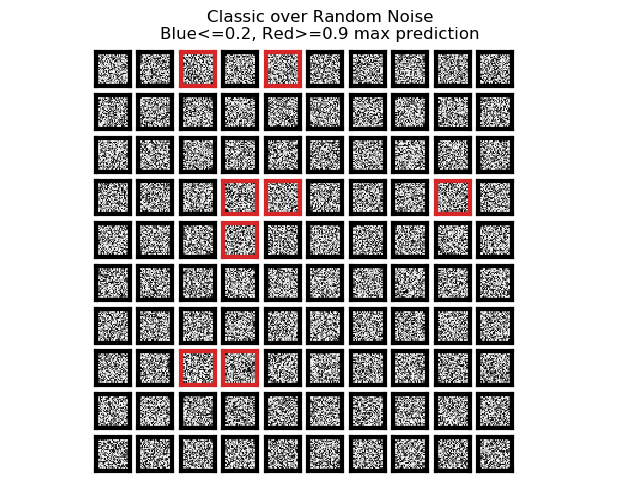

In [21]:
fgnh.plot_pred_samples_grid(classic_model, rand_noise_dataloader, title='Classic over Random Noise')

<IPython.core.display.Javascript object>


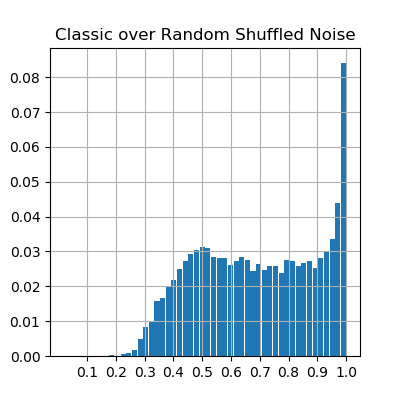

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.17800563160162922369, 0.9998754458672355063), mean=0.69031337728307471416, variance=0.042581278662531449374, skewness=-0.09144075608165261938, kurtosis=-1.2023482613604113483)

percentage of confident predictions (>=0.5): 0.773

Sample predictions
index 3043 prediction [0.01 0.03 0.   0.   0.   0.01 0.01 0.   0.95 0.  ]
index 629 prediction [0.   0.19 0.77 0.01 0.   0.   0.   0.01 0.01 0.  ]
index 5971 prediction [0.   0.19 0.07 0.02 0.   0.07 0.   0.65 0.   0.  ]
index 3719 prediction [0.   0.03 0.12 0.04 0.   0.41 0.   0.39 0.   0.  ]
index 2468 prediction [0.01 0.01 0.   0.02 0.   0.   0.   0.02 0.01 0.94]


In [22]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(classic_model, rand_shuffled_dataloader, title='Classic over Random Shuffled Noise' ,verbose=True)

<IPython.core.display.Javascript object>


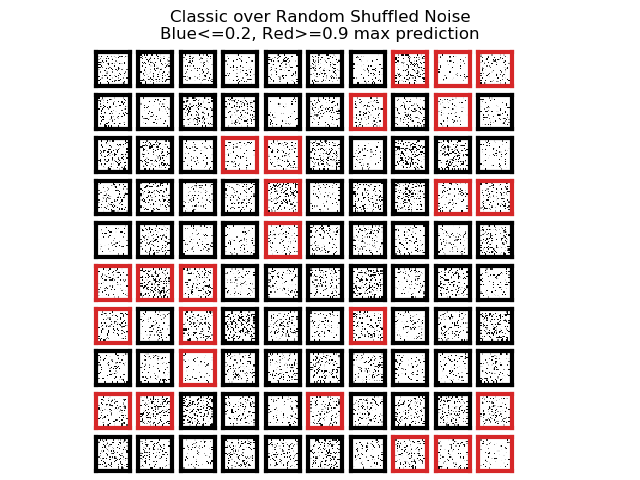

In [23]:
fgnh.plot_pred_samples_grid(classic_model, rand_shuffled_dataloader, title='Classic over Random Shuffled Noise')

# Part 2 - The converted Network

In [24]:
# print params to copy
!cat '../Experiments/sample_models/sample_classic_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [25]:
# params from classic
hidden_layer_sizes = [64,64]
drop_p = 0.2
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)

# fgn specific params
# covariance type: sphere, diag or full/chol
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

hidden layers: [64, 64]
drop prob: 0.2
covariance: sphere
ordinal for norm: 2.0
non linearity: True
free biases: True


In [26]:
# Initialize the fgn network
converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)

In [27]:
converted_fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [28]:
# convert from classic network
fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model, init_factor=1e1)

In [29]:
# set to eval mode
converted_fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [30]:
# test the accuracy of the model
# is it identical to above? (should be)
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0322, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0924, Accuracy: 9738/10000 (97%)


<IPython.core.display.Javascript object>


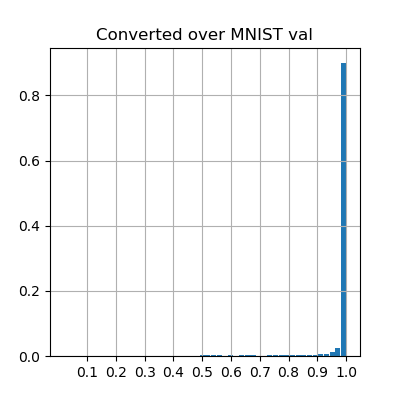

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29286713608202481207, 0.9999910047225139805), mean=0.9819050612842781989, variance=0.0049966450309294295564, skewness=-5.361713354656041666, kurtosis=30.952153511471782378)

percentage of confident predictions (>=0.5): 0.9958

Sample predictions
index 1259 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 8467 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3012 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 4281 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 8982 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Converted over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


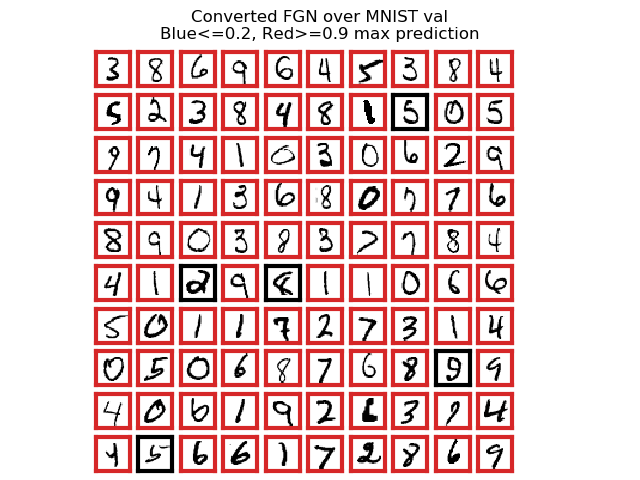

In [32]:
fgnh.plot_pred_samples_grid(converted_fgn_model, mnist_val_loader, title='Converted FGN over MNIST val')

In [33]:
# over letters now

<IPython.core.display.Javascript object>


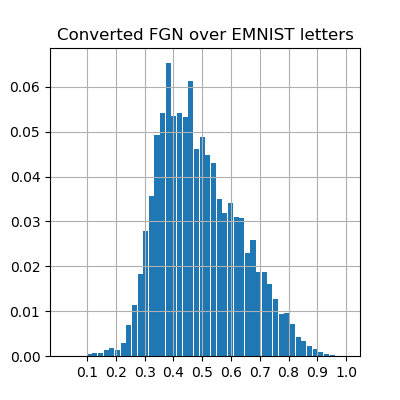

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.10003664019041150811, 0.963347439429215709), mean=0.4917972471896432394, variance=0.019623480131554056793, skewness=0.4645113170532457801, kurtosis=-0.30514646690067515197)

percentage of confident predictions (>=0.5): 0.42748397435897434

Sample predictions
index 9650 prediction [0.   0.02 0.06 0.7  0.01 0.06 0.   0.07 0.02 0.06]
index 10525 prediction [0.   0.02 0.05 0.05 0.04 0.18 0.   0.64 0.   0.02]
index 11419 prediction [0.   0.02 0.05 0.15 0.08 0.17 0.   0.44 0.   0.08]
index 9791 prediction [0.   0.03 0.05 0.1  0.06 0.23 0.   0.47 0.   0.06]
index 5339 prediction [0.   0.02 0.09 0.14 0.02 0.19 0.   0.46 0.   0.07]


In [34]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, emnist_val_loader, title='Converted FGN over EMNIST letters' ,verbose=True)

<IPython.core.display.Javascript object>


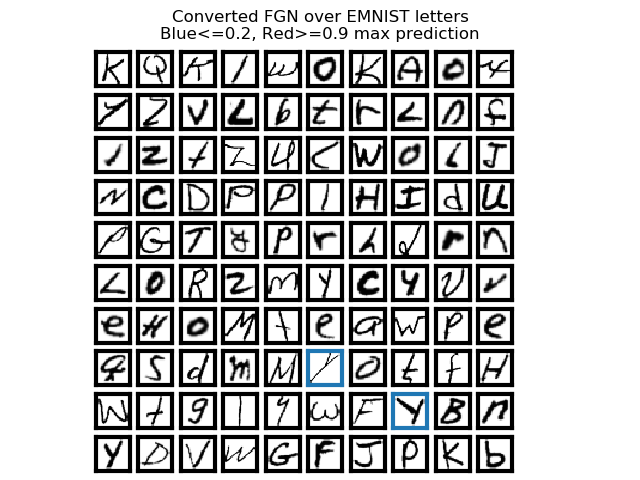

In [35]:
fgnh.plot_pred_samples_grid(converted_fgn_model, emnist_val_loader, title='Converted FGN over EMNIST letters')

In [36]:
# over noise now

<IPython.core.display.Javascript object>


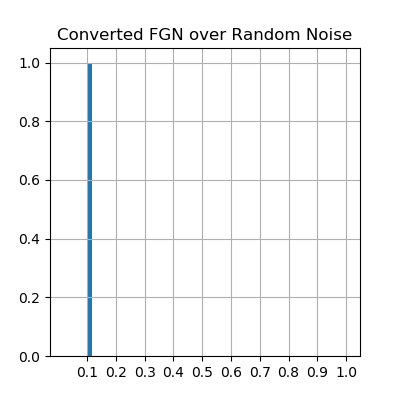

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.10000000003082224292, 0.100000107498885043904), mean=0.10000000349633288911, variance=2.5863114739118606742e-17, skewness=5.599531587819773502, kurtosis=59.919207197126248737)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7587 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 132 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6097 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 29 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8201 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [37]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random Noise' ,verbose=True)

<IPython.core.display.Javascript object>


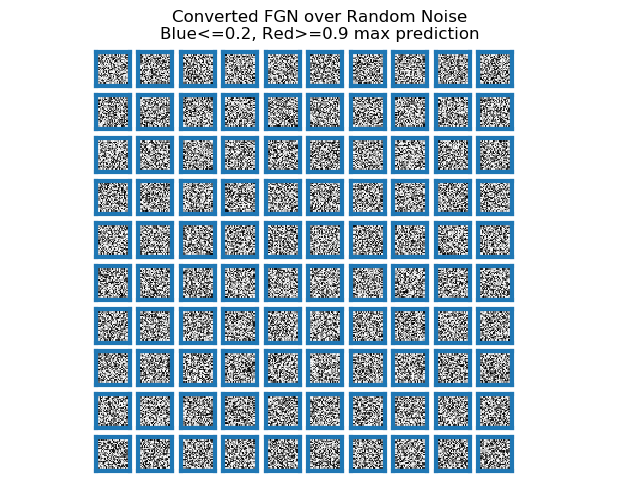

In [38]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random Noise')

<IPython.core.display.Javascript object>


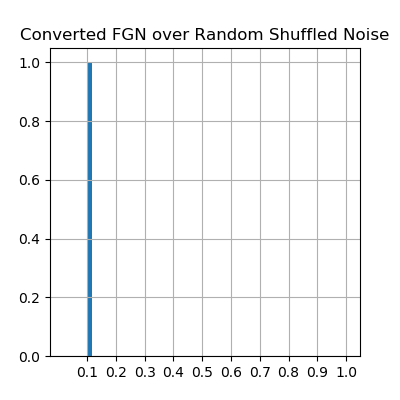

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.71589330251478061), mean=0.10020107342741423518, variance=7.2760705228317797476e-05, skewness=66.0664181414787625, kurtosis=4532.274768295116979)

percentage of confident predictions (>=0.5): 0.0002

Sample predictions
index 284 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 257 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8145 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4491 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7289 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [39]:
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random Shuffled Noise' ,verbose=True)

<IPython.core.display.Javascript object>


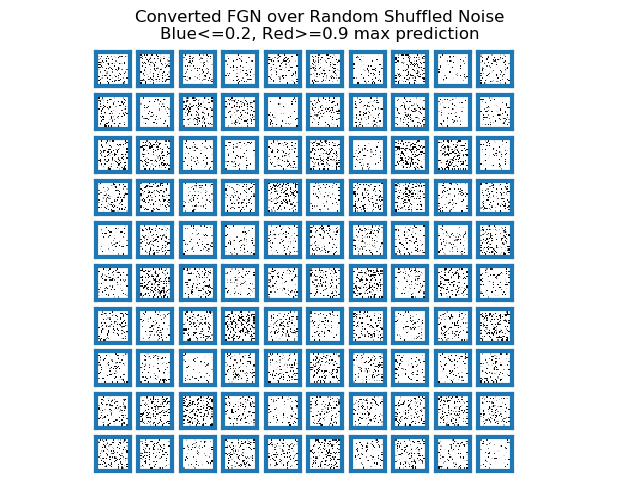

In [40]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random Shuffled Noise')

# Part 3 - Retraining

In [41]:
# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-7
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, converted_fgn_model.parameters()), lr=1e-3)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-07


In [42]:
# train the network for N epochs
epochs = 1
train_res = fgnh.train(converted_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 0.1031, Accuracy: 48420/50000 (97%)
Test set - Average loss: 0.0906, Accuracy: 9738/10000 (97%)


/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


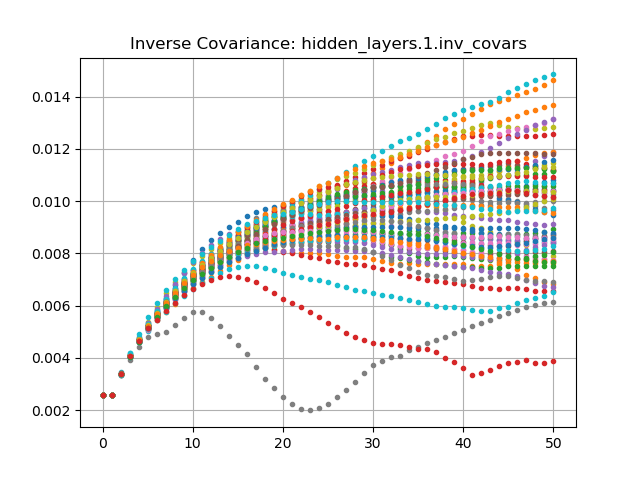

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


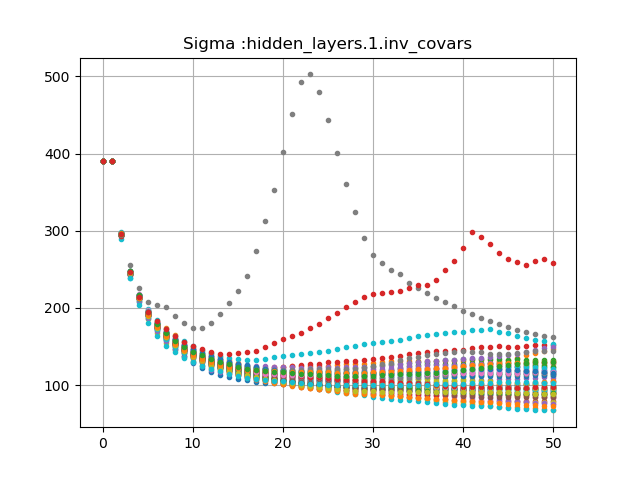

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


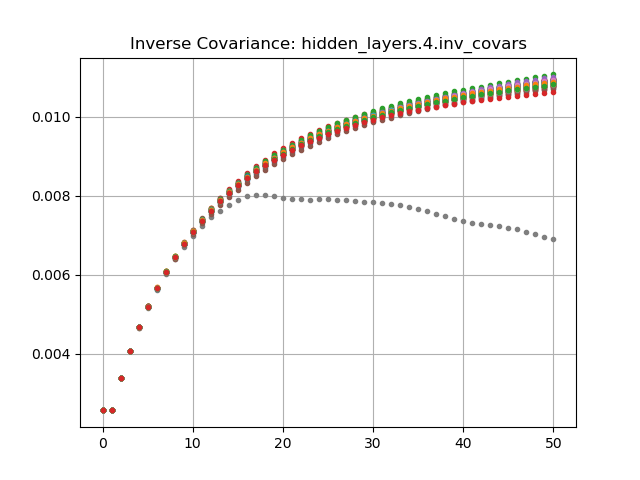

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


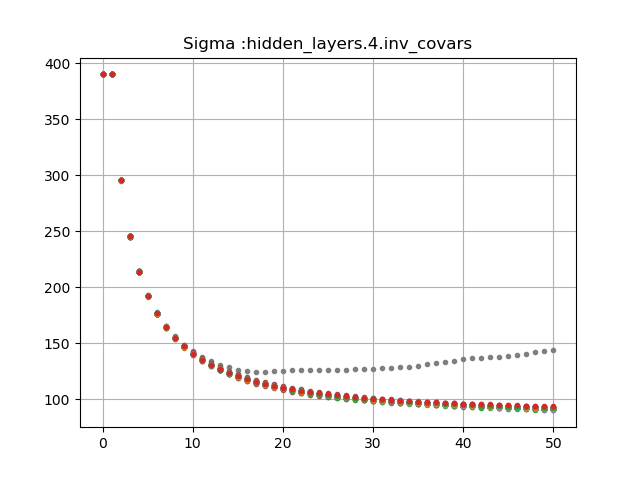

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


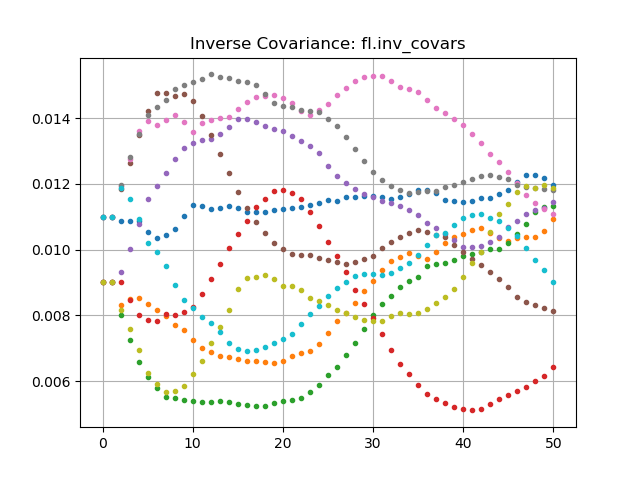

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


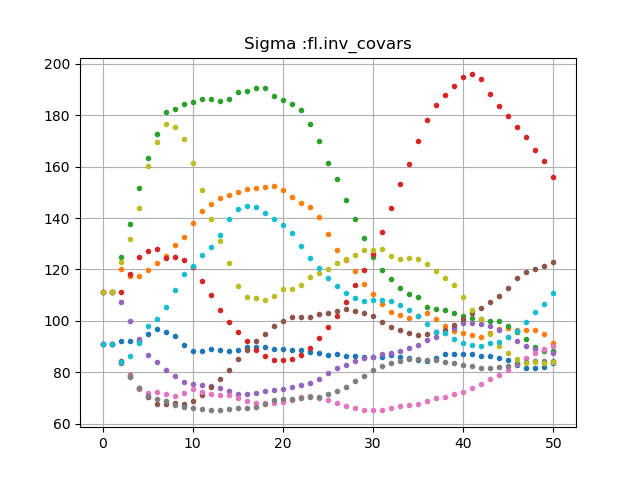

In [43]:
# check that inv_covar went up <=> sigmas went down
fgnl.plot_sigmas_histories(train_res['histories'])

In [44]:
# check accuracies
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0300, Accuracy: 49559/50000 (99%)
Test set - Average loss: 0.0897, Accuracy: 9738/10000 (97%)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


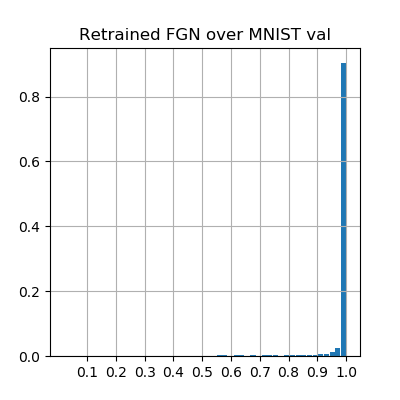

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.12247210956145524801, 0.99999327285490157807), mean=0.9825134026859131986, variance=0.0052083033007299862834, skewness=-5.8533337108174751363, kurtosis=38.72582159714207757)

percentage of confident predictions (>=0.5): 0.9942

Sample predictions
index 80 prediction [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
index 570 prediction [0.   0.   0.   0.01 0.   0.99 0.   0.   0.   0.  ]
index 3748 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 7274 prediction [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
index 7009 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


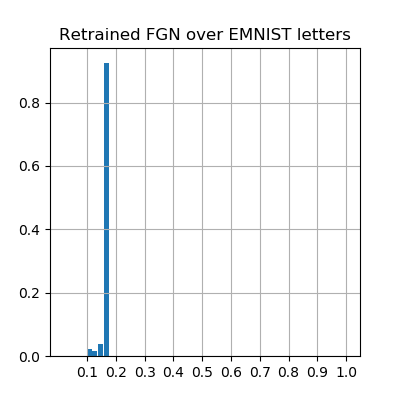

Statistical description of the predictions maximums
DescribeResult(nobs=12480, minmax=(0.1, 0.16562636283975633859), mean=0.15966491628717151221, variance=8.901917158476128635e-05, skewness=-4.9827401222293885843, kurtosis=25.321465498723676354)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 478 prediction [0.03 0.12 0.13 0.16 0.07 0.15 0.07 0.13 0.07 0.07]
index 2225 prediction [0.07 0.11 0.11 0.12 0.09 0.12 0.11 0.09 0.1  0.09]
index 1627 prediction [0.04 0.12 0.13 0.15 0.08 0.14 0.08 0.11 0.08 0.07]
index 10948 prediction [0.03 0.12 0.13 0.16 0.07 0.15 0.07 0.12 0.07 0.07]
index 9976 prediction [0.03 0.12 0.13 0.16 0.07 0.15 0.07 0.12 0.07 0.07]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


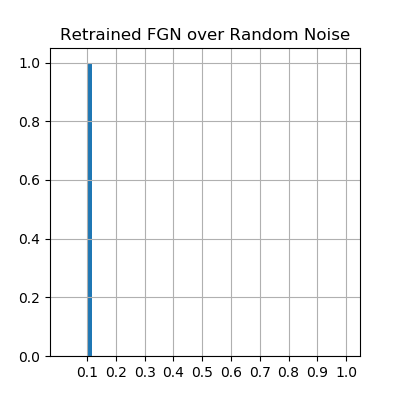

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 328 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3695 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 9511 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5681 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2613 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


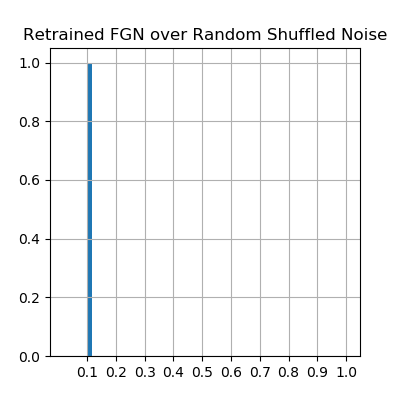

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.41705878907700927698), mean=0.10003222178025657785, variance=1.0054485430300961593e-05, skewness=99.95704416663523982, kurtosis=9991.240874209152235)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5997 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7897 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7489 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6057 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 383 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [45]:
# check histograms over MNIST, letters, noise, shuffled
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Retrained FGN over MNIST val', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, emnist_val_loader, title='Retrained FGN over EMNIST letters' ,verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Retrained FGN over Random Noise', verbose=True)
plt.figure(figsize=(4,4))
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Retrained FGN over Random Shuffled Noise', verbose=True)

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_samples_grid.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=10, ncols=10)


<IPython.core.display.Javascript object>


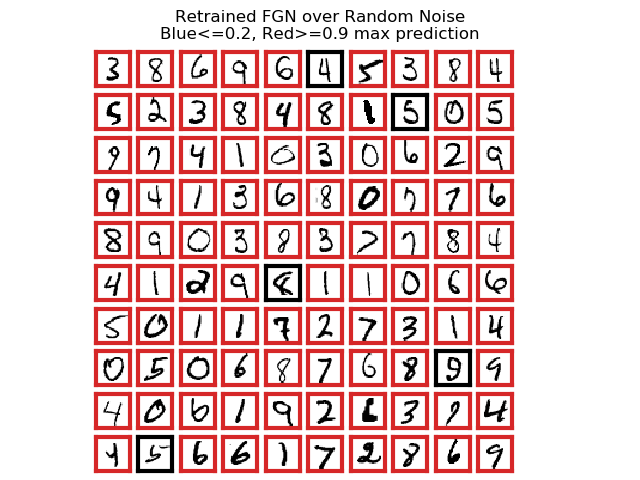

In [46]:
fgnh.plot_pred_samples_grid(converted_fgn_model, mnist_val_loader, title='Retrained FGN over Random Noise')

<IPython.core.display.Javascript object>


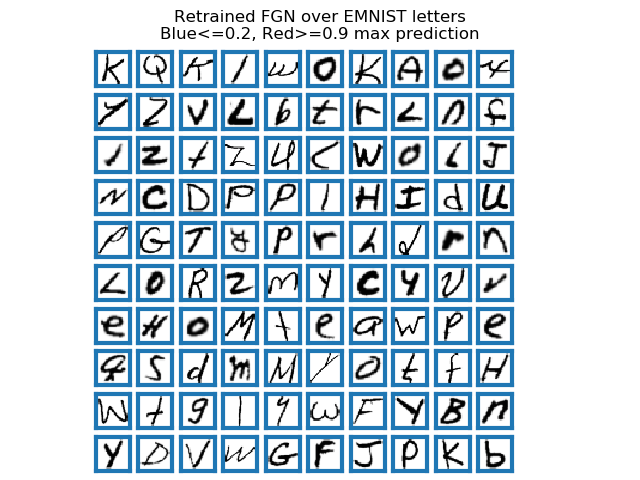

In [47]:
fgnh.plot_pred_samples_grid(converted_fgn_model, emnist_val_loader, title='Retrained FGN over EMNIST letters')

<IPython.core.display.Javascript object>


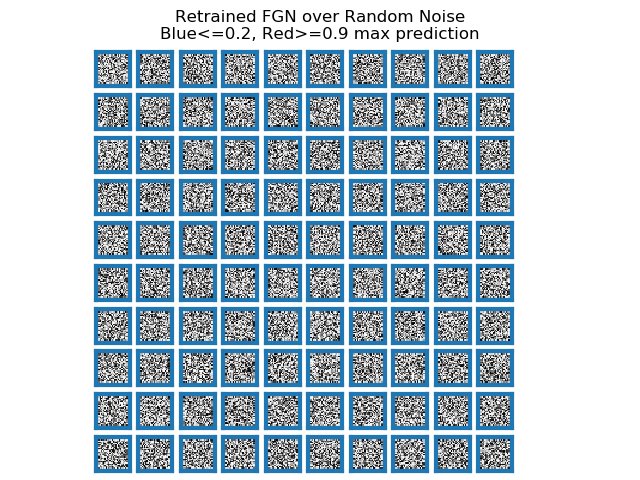

In [48]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_noise_dataloader, title='Retrained FGN over Random Noise')

<IPython.core.display.Javascript object>


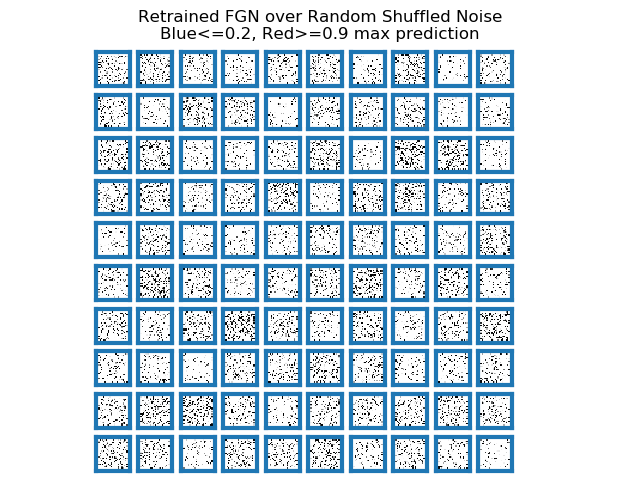

In [49]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_shuffled_dataloader, title='Retrained FGN over Random Shuffled Noise')